<a href="https://colab.research.google.com/github/lbrogna/drone-palms/blob/main/chip_unchip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math as m

def calculate_chips(image_width, image_height, num_chips):
    # calculate area of image
    image_area = image_width * image_height

    # calculate length of each side of a single chip
    chip_side_length = m.sqrt(image_area / num_chips)

    # calculate area of a single chip
    chip_area = m.sqrt(image_area / num_chips)

    # calculate number of chips in each dimension
    num_chips_per_dim = m.sqrt(num_chips)

    # calculate size of each chip
    chip_width = m.ceil(image_width / num_chips_per_dim)
    chip_height = m.ceil(image_height / num_chips_per_dim)

    # calculate overlap of each chip
    overlap_x = chip_width - chip_side_length
    overlap_y = chip_height - chip_side_length

    return chip_width, chip_height, m.ceil(overlap_x), m.ceil(overlap_y)

In [ ]:
import numpy as np
import cv2

def chip_tif(input_file, num_chips, scale, square):

    # scale : param specifying down/upscaling factor as decimal percentage
    # square : boolean, whether or not to make the image a square

    # input image
    image = cv2.imread(input_file, cv2.IMREAD_COLOR)

    height = image.shape[:2][0]
    width = image.shape[:2][1]

    if square == 1:
      max_dim = min(height, width)
      image = image[0:max_dim, 0:max_dim]
      dim = (int(max_dim * scale), int(max_dim * scale)) #up/downscaling
    else:
      dim = (int(width * scale), int(height * scale)) #up/downscaling

    image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    # save original dimensions for future remosaicking
    old_dims = image.shape[:2]

    # get image dimensions
    height, width = image.shape[:2]

    # calculate chips using previously defined function
    chip_width, chip_height, overlap_x, overlap_y = calculate_chips(width, height, num_chips)

    # create list to store the chips
    chips = []

    index = 0
    indices = []

    for i in range(0, height - chip_height + 1, chip_height - overlap_y):
        for j in range(0, width - chip_width + 1, chip_width - overlap_x):
            chip = image[i:i+chip_height, j:j+chip_width]
            chips.append(chip)

    return chips, (overlap_y, overlap_x), (chip_height, chip_width), old_dims

In [ ]:
# define the how many orthophotos you wish to select
n = 6

# define the number of chips per orthophoto
num_chips = 49

# define path to orthophoto folder
ortho_path = '/content/drive/MyDrive/drone_working/southern'

# define location to save chips
chips_path = '/content/drive/MyDrive/drone_working/chip_files/test'

In [ ]:
import random
import os

# set the random seed
seed = 72
random.seed(seed)

# list containing all files in folder
files = os.listdir(ortho_path)

# filter for only .tif files
tif_files = [file for file in files if file.endswith('.tif')]

# select n random orthophotos
random_tifs = random.sample(tif_files, n)


# chips saved here
for i, tif in enumerate(random_tifs):
  tif_path = os.path.join(ortho_path, tif)
  chips, o_lap, dims, old_dims = chip_tif(tif_path, num_chips, 0.18, square=1)
  ortho_chips_path = chips_path + f'/ortho_{i}'
  for j, chip in enumerate(chips):
    chip_filepath = ortho_chips_path + f'/chip_{j}.tif'
    cv2.imwrite(chip_filepath, chip)
  print('chipped orthophoto #' + str(i + 1) + ' - [ ' + str(tif_path) + ' ]' )
  print('original image dimensions: ' + str(old_dims))
  print('chip dimensions: ' + str(dims))
  print('chip overlaps: ' + str(o_lap))

print(' ----------- Chipping successful. Check Google Drive output destination. ----------- ')
print('\n')

chipped orthophoto #1 - [ /content/drive/MyDrive/drone_working/southern/ortho_cid1667_sid216_cog.tif ]
original image dimensions: (5004, 5004)
chip dimensions: (715, 715)
chip overlaps: (1, 1)
chipped orthophoto #2 - [ /content/drive/MyDrive/drone_working/southern/ortho_cid1344_sid115_cog.tif ]
original image dimensions: (4228, 4228)
chip dimensions: (604, 604)
chip overlaps: (0, 0)
chipped orthophoto #3 - [ /content/drive/MyDrive/drone_working/southern/ortho_cid1821_sid199_cog.tif ]
original image dimensions: (4632, 4632)
chip dimensions: (662, 662)
chip overlaps: (1, 1)
chipped orthophoto #4 - [ /content/drive/MyDrive/drone_working/southern/ortho_cid1857_sid116_cog.tif ]
original image dimensions: (4629, 4629)
chip dimensions: (662, 662)
chip overlaps: (1, 1)
chipped orthophoto #5 - [ /content/drive/MyDrive/drone_working/southern/ortho_cid1670_sid157_cog.tif ]
original image dimensions: (5255, 5255)
chip dimensions: (751, 751)
chip overlaps: (1, 1)
chipped orthophoto #6 - [ /content/

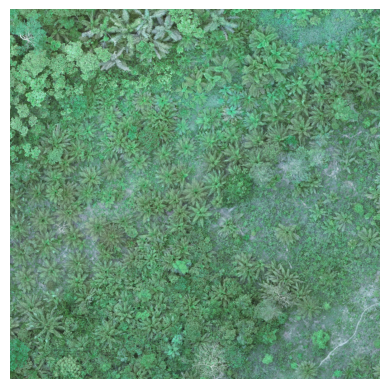

In [ ]:
import matplotlib.pyplot as plt

# select which orthophoto to display a chip from (indexed from 0 to n-1)
photo = 3

# select the chip to display below (indexed from 0 to num_chips-1)
x = 15

image = cv2.imread(f'/content/drive/MyDrive/drone_working/chip_files/ortho_{photo}/chip_{x}.tif')

# Display the chip
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
def ortho_remosaic(chips, image_shape, chip_dimensions, overlap, bands):
    # get image dimensions
    height, width = image_shape

    # initialize an empty canvas to reconstruct the image
    remosaicked_img = np.zeros((height, width, bands), dtype=np.float32)

    overlap_counts = np.zeros((height, width), dtype=np.uint8)

    # calculate the overlap between chips
    overlap_y, overlap_x = overlap

    # calculate the number of chips in each direction
    num_chips_y = int(np.ceil(height / chip_dimensions[0]))
    num_chips_x = int(np.ceil(width / chip_dimensions[1]))

    # reconstruct the image by placing each chip in the correct location
    chip_idx = 0

    for i in range(num_chips_y):
        for j in range(num_chips_x):
            y_start = i * (chip_dimensions[0] - overlap_y)
            y_end = min(y_start + chip_dimensions[0], height)

            x_start = j * (chip_dimensions[1] - overlap_x)
            x_end = min(x_start + chip_dimensions[1], width)

            chip = chips[chip_idx]

            # accumulate the chip into the reconstructed image
            remosaicked_img[y_start:y_end, x_start:x_end] += chip[:y_end-y_start, :x_end-x_start]
            overlap_counts[y_start:y_end, x_start:x_end] += 1

            chip_idx += 1
            if chip_idx >= len(chips):
                break
        if chip_idx >= len(chips):
            break

    overlap_counts = np.expand_dims(overlap_counts, axis=2)

    # average the overlapping regions
    remosaicked_img /= np.maximum(overlap_counts[...], 1)

    # convert the image back to uint8 data type
    remosaicked_img = np.round(remosaicked_img).astype(np.uint8)



    return remosaicked_img

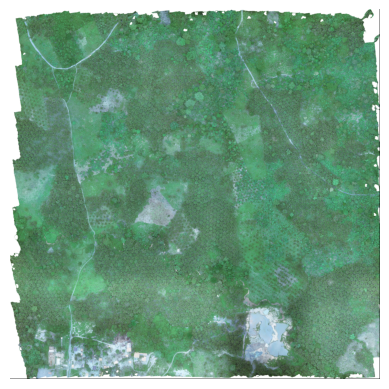

In [ ]:
out_path = '/content/drive/MyDrive/drone_working/test' # path to folder where this test will be saved

image_shape = old_dims  # dimensions of the original orthophoto
chip_dimensions = dims  # dimensions of each chip
overlap = o_lap  # overlap between chips

# reconstruct the orthophoto from chips
remosaicked_img = ortho_remosaic(chips, image_shape, chip_dimensions, overlap, bands=3)

# define paths for saving this test
ri_filepath = out_path + '/remosaick_test4.tif'
cv2.imwrite(ri_filepath, remosaicked_img)

ri = cv2.imread(ri_filepath)

# display the image
plt.imshow(ri)
plt.axis('off')
plt.show()